In [1]:
import preamble

import apps.generic.dataset as dataset
import examples.dataset as dataset_tool

import pprint as pp
import pandas as pd

### Node-to-node latency profiling

In [25]:
trial = "topo"
df, spec = dataset.load(bucket="perfd", 
                  app_name="meshping",
                  trial=trial)
raw = df.to_dict()
del raw["index"]

parsed = dict()
for k, v in raw.items():
    parsed[k] = v[0]
df = pd.DataFrame(parsed)
df = df[df["lat"].map(type) == float]

with pd.option_context('display.max_rows', None, 'display.max_columns',None):
    display(df.sort_values("lat"))

,src,dst,lat,numServerInstance,numClientInstance,serverInstanceType,clientInstanceType,mode,debug,tenancy
104,54.244.70.51,52.38.31.226,47,10,10,c5.xlarge,c5.xlarge,pairwise,True,dedicated
177,54.191.204.9,52.34.134.221,47,10,10,c5.xlarge,c5.xlarge,pairwise,True,dedicated
169,34.219.52.86,54.191.204.9,49,10,10,c5.xlarge,c5.xlarge,pairwise,True,dedicated
134,54.202.152.90,34.214.110.40,50,10,10,c5.xlarge,c5.xlarge,pairwise,True,dedicated
187,52.34.134.221,34.219.10.255,51,10,10,c5.xlarge,c5.xlarge,pairwise,True,dedicated
184,34.210.107.185,52.34.134.221,51,10,10,c5.xlarge,c5.xlarge,pairwise,True,dedicated
174,34.219.52.86,34.214.110.40,52,10,10,c5.xlarge,c5.xlarge,pairwise,True,dedicated
171,34.219.52.86,34.210.107.185,53,10,10,c5.xlarge,c5.xlarge,pairwise,True,dedicated
181,18.236.165.235,52.34.134.221,53,10,10,c5.xlarge,c5.xlarge,pairwise,True,dedicated
39,54.191.239.219,54.244.207.120,54,10,10,c5.xlarge,c5.xlarge,pairwise,True,dedicated


### CDF

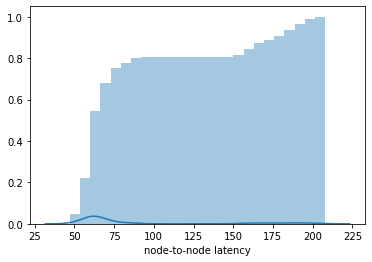

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

kwargs = {'cumulative': True}
sns.distplot(df["lat"], hist_kws=kwargs)
plt.xlabel("node-to-node latency")
print()

#### Setup: 
We provisioned EC2 20 c5.xlarge nodes/instances for experiments, each has 4-core;
#### Observation: 
About 20% of the nodes experience 2x higher latency;

#### Conjecture: 

When we request for 16 nodes of c5.xlarge (4-core each) dedicated, a 64-core physical machine (or a coarser grained placement unit, e.g., two servers within a rack) is given to us. When we request 20 nodes, the other 4 nodes are placed else where, latency to whom is larger across the nodes

### Evidence

In [23]:
# associate high latencies with the node IP
from collections import defaultdict
import pprint as pp

results = defaultdict(list)
for s, d, l in zip(df["src"].to_list(), df["dst"].to_list(), df["lat"].to_list()):
    if l > 100:
        results["high_src"].append(s)
        results["high_dst"].append(d)
    else:
        results["low_src"].append(s)
        results["low_dst"].append(d)
        
for k, v in results.items():
    results[k] = set(sorted(v))
    
intersect = results["low_dst"].intersection(results["low_src"])
print("'Good' instances (instances that never involve in tail latencies):\n"); pp.pprint(intersect)
print("\nNumber of 'good' instances:", len(intersect))

'Good' instances (instances that never involve in tail latencies):

{'18.236.165.235',
 '18.237.89.215',
 '34.210.107.185',
 '34.212.107.62',
 '34.219.10.255',
 '34.219.52.86',
 '34.221.205.15',
 '52.34.134.221',
 '52.38.31.226',
 '52.41.112.176',
 '54.191.204.9',
 '54.191.239.219',
 '54.202.152.90',
 '54.244.207.120',
 '54.244.70.51',
 '54.70.147.149'}

Number of 'good' instances: 16
